# Image Captioning

In [ ]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -q adityajn105/flickr8k
! unzip -q 'flickr8k.zip'
! pip install -q image-classifiers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.7 MB/s eta 0:00:00


## Required Libraries

In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize, convert_image_dtype
from keras.utils import load_img, img_to_array, to_categorical, plot_model, pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

from classification_models.keras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

## Dataset Loader and Preprocessor

In [ ]:
images_dir = 'Images'
image_dim = 224

def load_image(img_name):
    img_path = os.path.join(images_dir, img_name)
    img = load_img(img_path)
    img = img_to_array(img)
    img = resize(img, (image_dim, image_dim))
    img = convert_image_dtype(img, tf.float32)
    return img

def preprocess_caption(caption):
    caption = re.sub('[^a-z ]+', '', caption.lower())
    caption = re.sub(r'\b\w{1}\b', '', caption)
    caption = re.sub(' +', ' ', caption.strip())
    caption = caption + ' endseq'
    return caption

def load_dataset():
    dataset = {}
    for img_name in tqdm(os.listdir(images_dir)):
        img = load_image(img_name)
        dataset[img_name] = {'image': img, 'captions': []}

    with open('captions.txt', 'r') as cap_file:
        next(cap_file)
        for line in cap_file:
            img_name, caption = line.rstrip().split(',', 1)
            caption = preprocess_caption(caption)
            dataset[img_name]['captions'].append(caption)

    return dataset

def split_dataset(dataset, train_size=0.9):
    all_keys = list(dataset.keys())
    train_keys, test_keys = train_test_split(
        all_keys, train_size=train_size, random_state=85)
    return train_keys, test_keys

In [ ]:
def get_tokenizer(dataset):

    all_captions = []
    for item in list(dataset.items()):
        for caption in item[1]['captions']:
            all_captions.append(caption)

    print('total captions =', len(all_captions))
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)

    vocab_size = len(tokenizer.word_index) + 1
    print('vocabulary size =', vocab_size)

    max_length = max(caption.count(' ') for caption in all_captions) + 1
    print('maximum length =', max_length)

    return tokenizer, vocab_size, max_length

## Custom Data Generator

In [ ]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, dataset, key_list, tokenizer,
                 max_length, batch_size=32, shuffle=True):

        self.dataset = dataset
        self.key_list = key_list
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_list) // self.batch_size

    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        batch_indxs = self.indexes[start:end]
        return self.__generate_batch(batch_indxs)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.key_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __generate_batch(self, batch_indxs):
        X1, X2, y = [], [], []

        for i in batch_indxs:
            key = self.key_list[i]
            img = self.dataset[key]['image']
            img = preprocess_input(img)

            captions = self.dataset[key]['captions']
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                in_seq, out_seq = seq[:-1], seq
                X1.append(img)
                X2.append(in_seq)
                y.append(out_seq)

        X2 = pad_sequences(X2, maxlen=self.max_length-1, padding='post')
        y = pad_sequences(y, maxlen=self.max_length, padding='post')
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return [X1, X2], y

## CNN + LSTM Model

In [ ]:
def build_model(trainable_cnn):

    resNet = ResNet18(
        include_top=False, weights="imagenet", input_shape=(image_dim, image_dim, 3))

    resNet.trainable = trainable_cnn

    input1 = keras.layers.Input(shape=(image_dim, image_dim, 3))
    x = resNet(input1, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(300, activation=keras.layers.LeakyReLU(alpha=0.05))(x)
    features = keras.layers.Reshape((1, 300))(x)

    input2 = keras.layers.Input(shape=(max_length-1,))
    embeddings = keras.layers.Embedding(vocab_size, 300)(input2)

    x = keras.layers.Concatenate(axis=1)([features, embeddings])
    x = keras.layers.LSTM(256, return_sequences=True, dropout=0.2)(x)
    output = keras.layers.Dense(vocab_size, activation='softmax')(x)

    model = keras.models.Model(inputs=[input1, input2], outputs=output)

    return model

In [ ]:
def generate_caption(model, indx):
    img = dataset[test_keys[indx]]['image']
    img = np.array(img, dtype=np.uint8)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    img = preprocess_input(img)
    img = tf.reshape(img, (1, image_dim, image_dim, 3))
    seq = np.zeros((1, max_length-1))
    EOS = tokenizer.texts_to_sequences(["endseq"])[0][0]

    for i in range(max_length-1):
        res = model.predict([img, seq], verbose=0)
        res = np.argmax(res, axis=2)
        seq[0][i] = res[0][i]

        if seq[0][i] == EOS: break

    print()
    print(tokenizer.sequences_to_texts(seq)[0])

In [ ]:
def compile_model(model, learning_rate=0.005, decay_rate=0.85):

    steps_per_epoch = len(train_data)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay (
        learning_rate, decay_steps=steps_per_epoch,
        decay_rate=decay_rate, staircase=True
    )

    adam = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [ ]:
def plot_training_history(history):
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

## Preparing the Dataset

In [ ]:
dataset = load_dataset()
print('\ndataset size =', len(dataset))

tokenizer, vocab_size, max_length = get_tokenizer(dataset)

train_keys, test_keys = split_dataset(dataset, train_size=0.9)

train_data = DataGenerator(dataset, train_keys, tokenizer, max_length, batch_size=32)
test_data = DataGenerator(dataset, test_keys, tokenizer, max_length, batch_size=16)

100%|██████████| 8091/8091 [01:08<00:00, 117.37it/s]



dataset size = 8091
total captions = 40455
vocabulary size = 8767
maximum length = 33


## Training the Model 1 (Freezed CNN)

In [11]:
model_1 = build_model(trainable_cnn=False)
compile_model(model_1)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model_1.h5',
    monitor='val_loss',
    save_best_only=True)

history_1 = model_1.fit (
    train_data, validation_data=test_data,
    callbacks=[checkpoint], epochs=15)

44920640/44920640 [==============================] - 0s 0us/step
Epoch 1/15
227/227 [==============================] - 104s 396ms/step - loss: 1.7495 - val_loss: 1.3386
Epoch 2/15
227/227 [==============================] - 57s 251ms/step - loss: 1.2675 - val_loss: 1.2127
Epoch 3/15
227/227 [==============================] - 56s 244ms/step - loss: 1.1526 - val_loss: 1.1562
Epoch 4/15
227/227 [==============================] - 55s 243ms/step - loss: 1.0786 - val_loss: 1.1202
Epoch 5/15
227/227 [==============================] - 56s 245ms/step - loss: 1.0219 - val_loss: 1.0969
Epoch 6/15
227/227 [==============================] - 56s 248ms/step - loss: 0.9774 - val_loss: 1.0845
Epoch 7/15
227/227 [==============================] - 56s 247ms/step - loss: 0.9398 - val_loss: 1.0788
Epoch 8/15
227/227 [==============================] - 55s 243ms/step - loss: 0.9085 - val_loss: 1.0713
Epoch 9/15
227/227 [==============================] - 56s 245ms/step - loss: 0.8827 - val_loss: 1.0698
Epoch 1

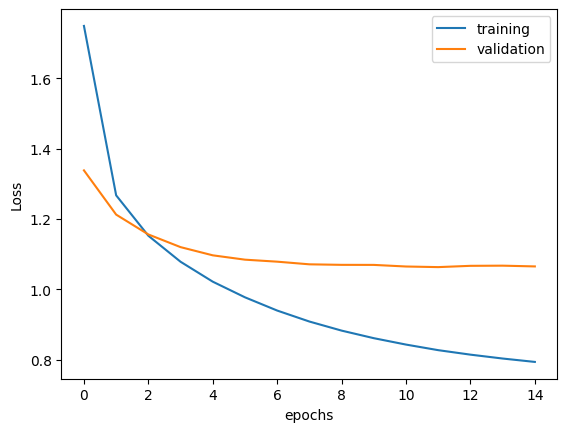

In [12]:
plot_training_history(history_1)

## Model 1 Test and Evaluation

In [13]:
best_model_1 = keras.models.load_model('best_model_1.h5')

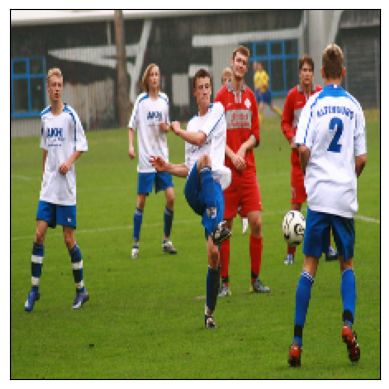


two men in red and white uniforms are playing soccer endseq


In [14]:
generate_caption(best_model_1, 1)

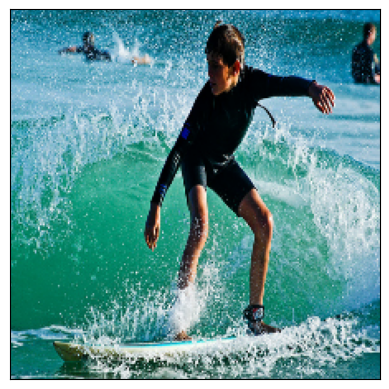


man in blue kayak paddles down river rapids endseq


In [15]:
generate_caption(best_model_1, 2)

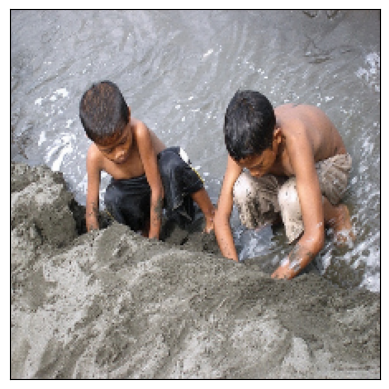


two boys are playing in water fountain endseq


In [16]:
generate_caption(best_model_1, 99)

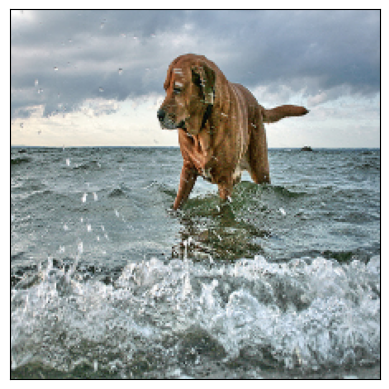


dog is running through the water endseq


In [17]:
generate_caption(best_model_1, 798)

## Training the Model 2 (Unfreezed CNN)

In [18]:
keras.backend.clear_session()

model_2 = build_model(trainable_cnn=True)
compile_model(model_2)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model_2.h5',
    monitor='val_loss',
    save_best_only=True)

history_2 = model_2.fit (
    train_data, validation_data=test_data,
    callbacks=[checkpoint], epochs=15)

Epoch 1/15
227/227 [==============================] - 165s 649ms/step - loss: 1.8556 - val_loss: 1.4101
Epoch 2/15
227/227 [==============================] - 139s 613ms/step - loss: 1.3322 - val_loss: 1.2635
Epoch 3/15
227/227 [==============================] - 141s 619ms/step - loss: 1.2121 - val_loss: 1.2029
Epoch 4/15
227/227 [==============================] - 142s 623ms/step - loss: 1.1431 - val_loss: 1.1710
Epoch 5/15
227/227 [==============================] - 143s 630ms/step - loss: 1.0931 - val_loss: 1.1548
Epoch 6/15
227/227 [==============================] - 141s 619ms/step - loss: 1.0560 - val_loss: 1.1418
Epoch 7/15
227/227 [==============================] - 141s 619ms/step - loss: 1.0247 - val_loss: 1.1329
Epoch 8/15
227/227 [==============================] - 146s 642ms/step - loss: 0.9998 - val_loss: 1.1301
Epoch 9/15
227/227 [==============================] - 151s 666ms/step - loss: 0.9787 - val_loss: 1.1274
Epoch 10/15
227/227 [==============================] - 169s 746m

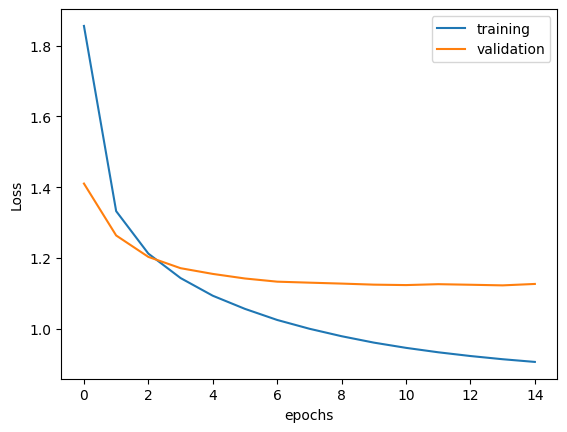

In [19]:
plot_training_history(history_2)

## Model 2 Test and Evaluation

In [20]:
best_model_2 = keras.models.load_model('best_model_2.h5')

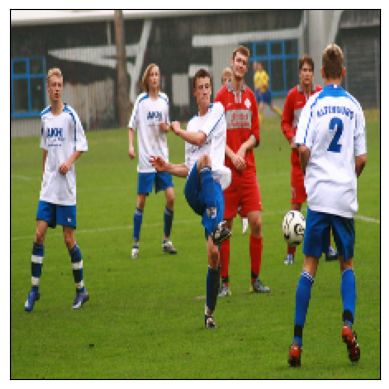


man in black shirt and black pants is standing on the sidewalk endseq


In [21]:
generate_caption(best_model_2, 1)

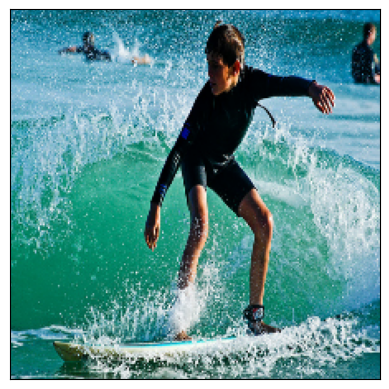


man in black shirt and black pants is standing on the sidewalk endseq


In [22]:
generate_caption(best_model_2, 2)

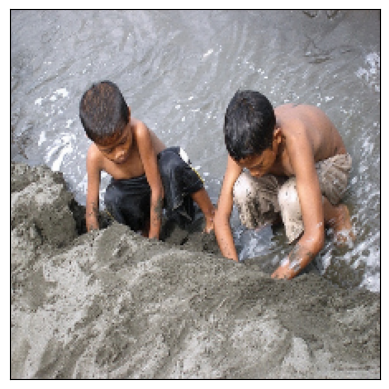


man in black shirt and black pants is standing on the sidewalk endseq


In [23]:
generate_caption(best_model_2, 99)

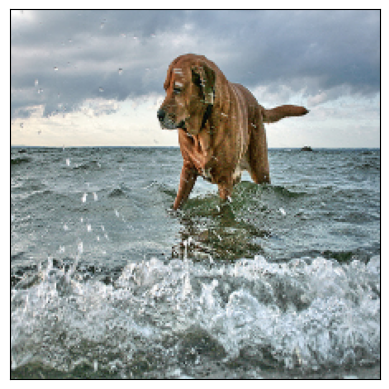


man in black shirt and black pants is standing on the sidewalk endseq


In [24]:
generate_caption(best_model_2, 798)